⚠️ GPU not found. Running on CPU.
Loading tokenizer: allenai/scibert_scivocab_uncased


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading PRE-TRAINED model: allenai/scibert_scivocab_uncased
Model and tokenizer loaded successfully.
Loading evaluation data from data/processed/evaluation_dataset_rich.jsonl...
Sampling 1 query per dataset...
Fetching abstracts from DB...
Dataset created: 50 pairs (Positive: 50)
Calculating embeddings for 'abstract_a'...


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Calculating embeddings for 'abstract_b'...


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Calculating cosine similarity...
Analysis complete.


,cosine_similarity,label
0,0.882683,1
1,0.584106,1
2,0.894018,1
3,0.916944,1
4,0.360231,1



--- Visualization 1: Positive vs. Negative Distribution (Evaluation Set) ---


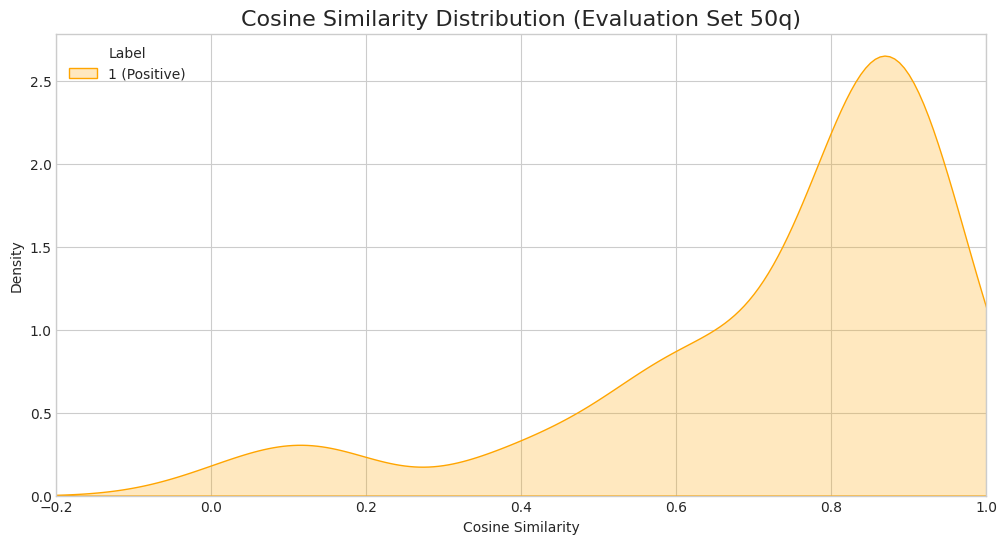


--- Statistics ---
Positive Pairs (label=1):


count    50.000000
mean      0.728895
std       0.237645
min       0.014769
25%       0.619010
50%       0.842205
75%       0.884404
max       0.955572
Name: cosine_similarity, dtype: float64

In [7]:
import json
import sqlite3
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
import random
from IPython.display import display

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

# --- 2. 設定 ---
EVAL_FILE = "data/processed/evaluation_dataset_rich.jsonl"
DB_PATH = "data/processed/s2orc_filtered.db"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"
SEED = 42
MAX_LENGTH = 512
INFERENCE_BATCH_SIZE = 32

# --- 3. モデルとトークナイザのロード ---
print(f"Loading tokenizer: {MODEL_CHECKPOINT}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print(f"Loading PRE-TRAINED model: {MODEL_CHECKPOINT}")
model = AutoModel.from_pretrained(MODEL_CHECKPOINT).to(device)
model.eval()
print("Model and tokenizer loaded successfully.")

# --- 4. データセットの読み込みと構築 ---
print(f"Loading evaluation data from {EVAL_FILE}...")
all_queries = []
with open(EVAL_FILE, 'r') as f:
    for line in f:
        data = json.loads(line)
        if not data.get("query_abstract"):
            continue
        all_queries.append({
            "query_text": data["query_abstract"],
            "ground_truth_dois": data["ground_truth_dois"],
            "data_paper_doi": data.get("metadata", {}).get("source_datapaper", "unknown")
        })

# 50件サンプリング (データセットごとに1つ)
print("Sampling 1 query per dataset...")
random.seed(SEED)
grouped = {}
for q in all_queries:
    src = q["data_paper_doi"]
    if src not in grouped:
        grouped[src] = []
    grouped[src].append(q)

sampled_data = []
for src, group in grouped.items():
    selected = random.choice(group)
    # 正解DOI (最初の1つを採用)
    gt_doi = selected["ground_truth_dois"][0]
    sampled_data.append({
        "query_text": selected["query_text"],
        "paper_doi": gt_doi,
        "label": 1 # Positive
    })

# アブストラクトの取得
print("Fetching abstracts from DB...")
doi_to_abstract = {}
target_dois = [d['paper_doi'] for d in sampled_data]

with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    chunk_size = 500
    for i in range(0, len(target_dois), chunk_size):
        chunk = target_dois[i:i+chunk_size]
        placeholders = ','.join('?' for _ in chunk)
        cursor.execute(f"SELECT doi, abstract FROM papers WHERE doi IN ({placeholders})", chunk)
        for row in cursor:
            text = row[1].replace("\n", " ").strip() if row[1] else ""
            if len(text) > 50:
                doi_to_abstract[row[0]] = text

# 正例データの構築
pos_rows = []
valid_texts = [] # 負例生成用
for d in sampled_data:
    abstract = doi_to_abstract.get(d['paper_doi'])
    if abstract:
        pos_rows.append({
            "abstract_a": d['query_text'],
            "abstract_b": abstract,
            "label": 1
        })
        valid_texts.append(abstract)

# 結合
df = pd.DataFrame(pos_rows)
print(f"Dataset created: {len(df)} pairs (Positive: {len(pos_rows)})")
# Hugging Face Datasetに変換
dataset = Dataset.from_pandas(df)

# --- 5. Embedding関数の定義 ---
def get_cls_embeddings(batch_texts):
    inputs = tokenizer(
        batch_texts, 
        padding="max_length", 
        truncation=True, 
        max_length=MAX_LENGTH, 
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # SciBERT / SPECTER では [CLS] トークン (pooler_output または last_hidden_state[:, 0]) を使う
    # ここでは以前のコードに合わせて pooler_output を使用
    cls_embeddings = outputs.pooler_output
    return cls_embeddings.cpu().numpy()

# --- 6. 全ペアのベクトル化と類似度計算 ---
print("Calculating embeddings for 'abstract_a'...")
vecs_a = dataset.map(
    lambda batch: {'vec_a': get_cls_embeddings(batch['abstract_a'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_a']

print("Calculating embeddings for 'abstract_b'...")
vecs_b = dataset.map(
    lambda batch: {'vec_b': get_cls_embeddings(batch['abstract_b'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_b']

print("Calculating cosine similarity...")
vecs_a_tensor = torch.tensor(np.array(vecs_a))
vecs_b_tensor = torch.tensor(np.array(vecs_b))

cos_sim = F.cosine_similarity(vecs_a_tensor, vecs_b_tensor, dim=1)

df_results = pd.DataFrame({
    'cosine_similarity': cos_sim.numpy(),
    'label': dataset['label']
})

print("Analysis complete.")
display(df_results.head())

# --- 7. 可視化1: 正例と負例の分布の比較 ---
print("\n--- Visualization 1: Positive vs. Negative Distribution (Evaluation Set) ---")

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# データ数が少ないため、bw_adjustを少し大きめにして滑らかにする
sns.kdeplot(
    data=df_results, 
    x='cosine_similarity', 
    fill=True, 
    common_norm=False,
    bw_adjust=0.8,
    color='orange',
    clip=(-1.0, 1.0),
)

plt.title('Cosine Similarity Distribution (Evaluation Set 50q)', fontsize=16)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.xlim(-0.2, 1.0)
plt.legend(title='Label', labels=['1 (Positive)'])
plt.show()

print("\n--- Statistics ---")
print("Positive Pairs (label=1):")
display(df_results[df_results['label']==1]['cosine_similarity'].describe())

